# Developing an empirical model from a process reaction curve

i.e. conduct a unit step change in the input $u(t)$, record the output $y$ as a function of time $t$.

Load some useful packages.

![](https://upload.wikimedia.org/wikipedia/commons/6/69/Julia_prog_language.svg)

In [1]:
# PyPlot.matplotlib[:style][:use]("seaborn")
# plt.matplotlib[:rcParams]["axes.facecolor"] = (1.0,1.0,1.0,0.0)
# plt.matplotlib[:rcParams]["savefig.transparent"] = true

In [2]:
import PyPlot; const plt = PyPlot # plotting library
using DataFrames # working with data
using CSV # loading a comma-separated data file
using Optim # optimization package

## load the data

In [3]:
df = CSV.read("step_response2.csv")
head(df)

,t_expt,y
1,0.0,16.1826
2,0.0675676,16.0181
3,0.135135,16.0582
4,0.202703,15.8626
5,0.27027,16.1345
6,0.337838,16.1833


## viz the data

the step input change was conducted at $t=1$.

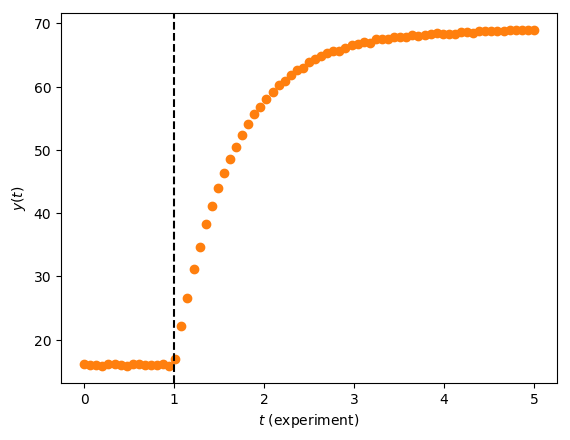

In [4]:
fig = plt.figure()
fig[:patch][:set_alpha](0.0)
plt.scatter(df[:t_expt], df[:y], color="C1")
plt.xlabel("\$t\$ (experiment)")
plt.ylabel("\$y(t)\$")
plt.axvline(x=1.0, color="k", linestyle="--")
plt.show()

looks like a typical first order response! 

let's try the transfer function model:
\begin{equation}
    G(s)= \frac{K}{\tau s + 1}
\end{equation}

so the expected response is:

\begin{equation}
    y^*(t)= K (1 - e^{t/\tau}).
\end{equation}

## but 

to fit 

\begin{equation}
    y^*(t)= K (1 - e^{t/\tau}).
\end{equation}

to process reaction data, need to:
* cast output $y$ in deviation form $y^*=y-\hat{y}$.
* shift time so that step occurs at $t=0$

Make $t=0$ be the time that the step occurs.

Subtract 1.0 since this was the time the input step was induced in the experiment.

In [5]:
df[:t] = df[:t_expt] - 1.0
head(df)

,t_expt,y,t
1,0.0,16.1826,-1.0
2,0.0675676,16.0181,-0.932432
3,0.135135,16.0582,-0.864865
4,0.202703,15.8626,-0.797297
5,0.27027,16.1345,-0.72973
6,0.337838,16.1833,-0.662162


declare $\bar{y}$ as the average $y$-value before the step input occurred

In [6]:
ȳ = mean(df[df[:t] .< 0.0, :][:y])

16.025268919747944

declare the deviation variable $y^*=y-\bar{y}$

In [7]:
df[:y_star] = df[:y] - ȳ
head(df)

,t_expt,y,t,y_star
1,0.0,16.1826,-1.0,0.157349
2,0.0675676,16.0181,-0.932432,-0.00719451
3,0.135135,16.0582,-0.864865,0.0329205
4,0.202703,15.8626,-0.797297,-0.162708
5,0.27027,16.1345,-0.72973,0.109203
6,0.337838,16.1833,-0.662162,0.158062


Now plot the data in deviation form.

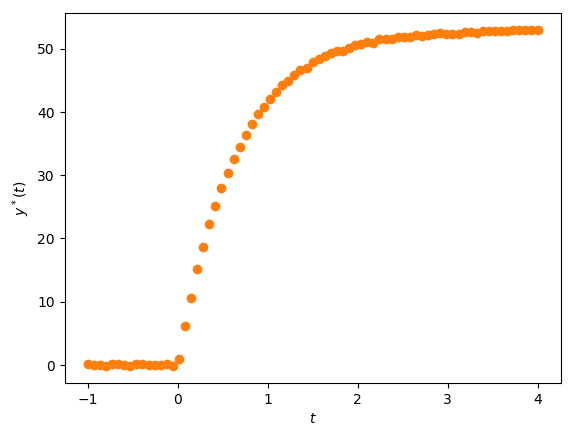

In [8]:
fig = plt.figure()
fig[:patch][:set_alpha](0.0)
plt.scatter(df[:t], df[:y_star], color="C1")
plt.xlabel("\$t\$")
plt.ylabel("\$y^*(t)\$")
plt.show()

let's throw away the data points before the step occurred.

these won't be used in our fitting procedure.

In [9]:
df = df[df[:t] .> 0.0, :]
head(df)

,t_expt,y,t,y_star
1,1.01351,16.9199,0.0135135,0.894595
2,1.08108,22.1676,0.0810811,6.14232
3,1.14865,26.6565,0.148649,10.6312
4,1.21622,31.1498,0.216216,15.1245
5,1.28378,34.6683,0.283784,18.643
6,1.35135,38.2622,0.351351,22.2369


## Data is ready

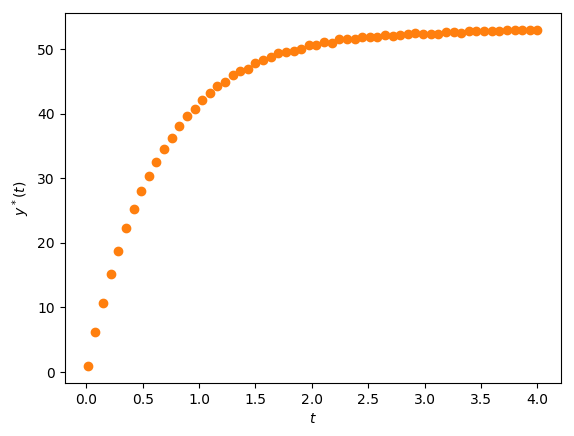

In [10]:
fig = plt.figure()
fig[:patch][:set_alpha](0.0)
plt.scatter(df[:t], df[:y_star], color="C1")
plt.xlabel("\$t\$")
plt.ylabel("\$y^*(t)\$")
plt.show()

## Preparing to fit model to data

Here's what we're fitting to:

\begin{equation}
    y^*(t)= K (1 - e^{t/\tau}).
\end{equation}

In [11]:
function y_star(t, K, τ)
    return K * (1.0 - exp(-t / τ))
end

y_star(6.0, 2.0, 0.7)

1.9996211163495343

For example if we guess $K=50$, $\tau=0.5$, here's a comparison of model to data

In [12]:
t = linspace(0.0, 4.0)
y_pred = y_star.(t, 50.0, 0.5)

50-element Array{Float64,1}:
  0.0    
  7.53171
 13.9289 
 19.3624 
 23.9775 
 27.8974 
 31.2268 
 34.0547 
 36.4566 
 38.4967 
 40.2295 
 41.7013 
 42.9513 
  ⋮      
 49.8989 
 49.9142 
 49.9271 
 49.9381 
 49.9474 
 49.9553 
 49.9621 
 49.9678 
 49.9726 
 49.9767 
 49.9803 
 49.9832 

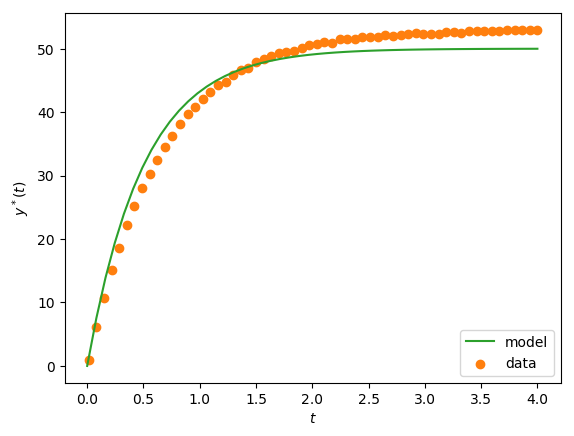

In [13]:
fig = plt.figure()
fig[:patch][:set_alpha](0.0)
plt.scatter(df[:t], df[:y_star], color="C1", label="data")
plt.plot(t, y_pred, color="C2", label="model")
plt.xlabel("\$t\$")
plt.ylabel("\$y^*(t)\$")
plt.legend(loc="lower right")
plt.show()

## write loss function $\ell(\beta)$

In [14]:
function sum_of_squares(β::Array{Float64, 1})
    K = β[1]
    τ = β[2]
    
    sum_of_squares = 0.0
    for row in eachrow(df)
        sum_of_squares += (row[:y_star] - y_star(row[:t], K, τ)) ^ 2
    end
    return sum_of_squares
end

sum_of_squares([50.0, 0.65])

402.5876333169071

## make a guess for $K$ and $\tau$

In [15]:
β_guess = [50, 0.5] # [K, τ]

2-element Array{Float64,1}:
 50.0
  0.5

## Minimize loss $\ell(\beta)$ with respect to $\beta=[K, \tau]$

Nelder-Mead algo

In [16]:
result = optimize(sum_of_squares, β_guess, NelderMead())

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [50.0,0.5]
 * Minimizer: [52.993981292943886,0.6512788587412965]
 * Minimum: 8.401652e-01
 * Iterations: 41
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 84

In [17]:
K, τ = result.minimizer

2-element Array{Float64,1}:
 52.994   
  0.651279

## what did we just do?
    
[the triangle dance of the Nelder-Mead algo](https://www.youtube.com/watch?v=KEGSLQ6TlBM)

[See Fig 6.4-5 here](http://adl.stanford.edu/aa222/lecture_notes_files/chapter6_gradfree.pdf)

## how did we do?

In [18]:
t = linspace(0.0, 4.0)
y_pred = y_star.(t, K, τ)

50-element Array{Float64,1}:
  0.0    
  6.24295
 11.7505 
 16.6091 
 20.8955 
 24.6768 
 28.0127 
 30.9556 
 33.5519 
 35.8422 
 37.8628 
 39.6453 
 41.2179 
  ⋮      
 52.5414 
 52.5947 
 52.6418 
 52.6833 
 52.7199 
 52.7522 
 52.7806 
 52.8058 
 52.8279 
 52.8475 
 52.8648 
 52.88   

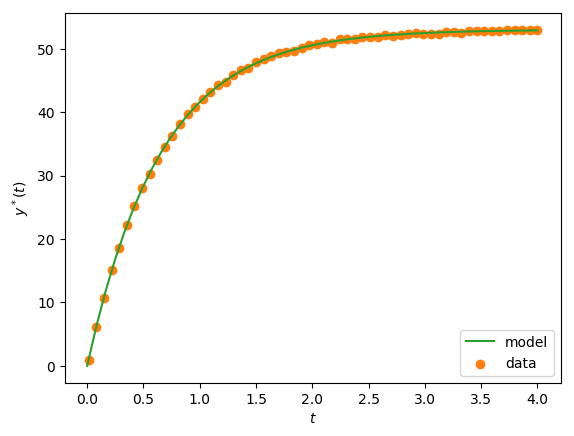

In [19]:
fig = plt.figure()
fig[:patch][:set_alpha](0.0)
plt.scatter(df[:t], df[:y_star], color="C1", label="data")
plt.plot(t, y_pred, color="C2", label="model")
plt.xlabel("\$t\$")
plt.ylabel("\$y^*(t)\$")
plt.legend(loc="lower right")
plt.show()

## Empirical model is:
\begin{equation}
    G(s) = \frac{53}{0.65 s + 1}
\end{equation}